# **DEPENDENCIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

import gdown

# **DATASET**

### Old Faithful Geyser Dataset

**Description**

Waiting time between eruptions ($\text{waiting}$) and the duration of the eruption ($\text{eruptions}$)
for the Old Faithful geyser in Yellowstone National Park, Wyoming,
USA.

A data frame with 272 observations on 2 variables.


In [6]:
gdown.download(
    "https://drive.google.com/uc?id=151I3geyIx1RaTLUTf4zsDTQKHpVRemau",
    "geyser.txt",
)

Downloading...
From: https://drive.google.com/uc?id=151I3geyIx1RaTLUTf4zsDTQKHpVRemau
To: c:\workspace-a\DS403-Introduction-to-Statistical-Learning-IIT-Mandi\DS403_Assignment_4_B20001\Q2\geyser.txt
100%|██████████| 6.61k/6.61k [00:00<00:00, 2.47MB/s]


'geyser.txt'

     eruptions  waiting
0        3.600     79.0
1        1.800     54.0
2        3.333     74.0
3        2.283     62.0
4        4.533     85.0
..         ...      ...
267      4.117     81.0
268      2.150     46.0
269      4.417     90.0
270      1.817     46.0
271      4.467     74.0

[272 rows x 2 columns]


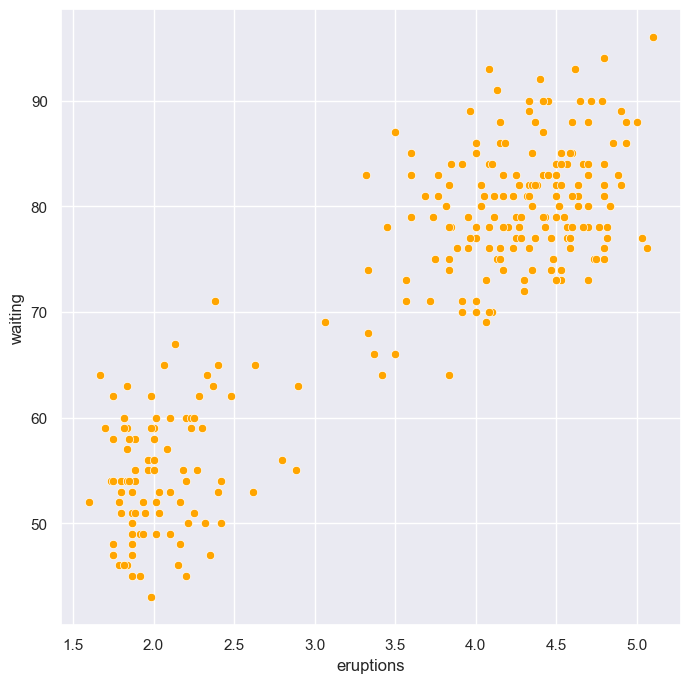

In [2]:
# Remove non numeric lines
with open("geyser.txt", "r") as f:
    lines = f.readlines()
    lines = [line for line in lines if line[0].isdigit()]
    lines = [line.split()[1:] for line in lines]
    lines = [[float(x) for x in line] for line in lines]

# Convert to Pandas DataFrame
df = pd.DataFrame(lines, columns=["eruptions", "waiting"])
print(df)

# Plot
plt.figure(figsize=(8, 8))
sns.set_theme(style="darkgrid")
sns.scatterplot(x="eruptions", y="waiting", data=df, color="orange")
plt.show()

Upon visual inspection the distribution of the data looks like a bimodal distribution. We will use the Gaussian Mixture Model to fit the data and see if we can recover the two modes.

# **GMM MODEL**

A Gaussian Mixture Model (GMM) is a probabilistic model that represents a mixture of multiple Gaussian distributions. The model assumes that the observed data is generated from a mixture of several Gaussian distributions, each characterized by its mean, covariance matrix, and weight in the mixture.

### Model Parameters:
- $ K $: Number of components in the mixture.
- $ \pi_k $: Mixing coefficient for the k-th component, representing the probability of choosing the k-th component.
- $ \mu_k $: Mean vector for the k-th component.
- $ \Sigma_k $: Covariance matrix for the k-th component. For the sake of simplicity and the assumption made in the code, I will assume a spherical covariance matrix, denoted as $ \sigma^2 I $, where $ I $ is the identity matrix.

### Objective:
Given a dataset $ X $, the GMM aims to maximize the likelihood of the observed data under the model.

### Model Representation:
The probability density function (pdf) of the GMM for a data point $ x $ is given by:

$ P(x) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x | \mu_k, \Sigma_k) $

Where $ \mathcal{N}(x | \mu_k, \Sigma_k) $ is the multivariate Gaussian distribution with mean $ \mu_k $ and covariance matrix $ \Sigma_k $.

### Expectation-Maximization (EM) Algorithm:
1. **Initialization:**
   - Initialize the mixing coefficients $ \pi_k $, mean vectors $ \mu_k $, and assume a spherical covariance matrix $ \Sigma_k = \sigma^2 I $. The parameters can be initialized randomly.

2. **E-step (Expectation):**
   - Compute the responsibilities $ \gamma_{nk} $, which represent the probability that data point $ x_n $ belongs to the k-th component:
     $ \gamma_{nk} = \frac{\pi_k \cdot \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_n | \mu_j, \Sigma_j)} $

3. **M-step (Maximization):**
   - Update the parameters to maximize the expected log-likelihood:
     $ \pi_k = \frac{1}{N} \sum_{n=1}^{N} \gamma_{nk} $
     $ \mu_k = \frac{\sum_{n=1}^{N} \gamma_{nk} \cdot x_n}{\sum_{n=1}^{N} \gamma_{nk}} $
     $ \Sigma_k = \frac{\sum_{n=1}^{N} \gamma_{nk} \cdot (x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^{N} \gamma_{nk}} $

4. **Termination:**
   - Repeat the E-step and M-step until convergence or until a maximum number of iterations is reached. Convergence is typically determined by monitoring the change in log-likelihood between iterations.

### Spherical Covariance Matrix Assumption:
In the code, the model assumes a spherical covariance matrix for each component, denoted as $ \sigma^2 I $. This simplification implies that the variance is the same along all dimensions, and there are no correlations between different dimensions.

### Handling the Assumptions:
1. **Spherical Covariance Matrix:**
   - The assumption of a spherical covariance matrix simplifies the model and reduces the number of parameters to estimate. However, it may not capture correlations between features in the data. If correlations are crucial, a full covariance matrix per component could be considered, but it would increase the complexity of the model.

2. **Random Initialization:**
   - Random initialization helps escape local optima during the optimization process. However, it can also lead to different results on each run. To address this, multiple random initializations can be performed, and the model with the highest likelihood can be selected.

### Stopping criteria:

The stopping criteria for the EM algorithm is the change in log-likelihood between iterations. If the change in log-likelihood is less than a threshold, the algorithm is terminated. For a detailed analysis of the stopping criteria, please refer to the following paper:

https://ieeexplore.ieee.org/document/4670413

In [79]:
class GaussianMixtureModel:
    def __init__(
        self, n_components, max_iterations=100, tolerance=1e-4, spherical_cov_mat=False
    ):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.spherical_cov_mat = spherical_cov_mat
        self.resp = None
        self.means = None
        self.covs = None
        self.weights = None
        self.converged = False

    def fit(self, X):
        # Initialize parameters
        n_row, n_col = X.shape
        self.resp = np.zeros((n_row, self.n_components))
        chosen = np.random.choice(n_row, self.n_components, replace=False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        shape = self.n_components, n_col, n_col
        if self.spherical_cov_mat:
            self.covs = np.full(shape, np.cov(X, rowvar=False).mean() * np.eye(n_col))
        else:
            self.covs = np.full(shape, np.cov(X, rowvar=False))

        log_likelihood = 0
        self.converged = False

        # fit_log
        fit_log = {
            "converged": False,
            "log_likelihood": [],
            "means": [],
            "weights": [],
            "covs": [],
        }

        for i in range(self.max_iterations):
            log_likelihood_new = self.e_step(X)
            self.m_step(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tolerance:
                self.converged = True
                fit_log["converged"] = i
                break

            log_likelihood = log_likelihood_new

            # Update fit_log
            fit_log["log_likelihood"].append(log_likelihood)
            fit_log["means"].append(self.means)
            fit_log["covs"].append(self.covs)
            fit_log["weights"].append(self.weights)

        return fit_log

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

    def e_step(self, X):
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis=1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis=1, keepdims=1)
        return log_likelihood

    def m_step(self, X):
        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis=0)

        # Update weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)

            # Handle spherical covariance matrix
            if self.spherical_cov_mat:
                self.covs[k] = np.diag(np.diag(weighted_sum)) / resp_weights[k]
            else:
                self.covs[k] = weighted_sum / resp_weights[k]

    def score(self, X):
        self._compute_log_likelihood(X)
        return np.sum(np.log(np.sum(self.resp, axis=1)))

    def update(self, new_data):
        # E-step
        self._compute_log_likelihood(new_data)

        # M-step
        self.m_step(new_data)

    def predict_proba(self, X):
        self._compute_log_likelihood(X)
        return self.resp

    def predict(self, X):
        self._compute_log_likelihood(X)
        return np.argmax(self.resp, axis=1)

    def plot_log_likelihood(self, fit_log):
        plt.figure(figsize=(8, 8))
        sns.set_theme(style="darkgrid")
        sns.lineplot(
            x=range(len(fit_log["log_likelihood"])), y=fit_log["log_likelihood"]
        )
        plt.title("Log Likelihood")
        plt.show()

    def plot_mean_trajectory(
        self, fit_log, data, col_indices, col_names=["Feature 1", "Feature 2"]
    ):
        data = data[:, col_indices]
        data = pd.DataFrame(data, columns=col_names)

        plt.figure(figsize=(8, 8))
        sns.set_theme(style="darkgrid")
        sns.scatterplot(
            x=col_names[0], y=col_names[1], data=data, color="gray", label="Data"
        )

        for k in range(self.n_components):
            means = np.array([log[k] for log in fit_log["means"]])
            plt.plot(
                means[:, col_indices[0]],
                means[:, col_indices[1]],
                label=f"Trajectory of mean: component {k}",
                marker="o",
                markersize=4,
            )
            # Initial mean
            plt.plot(
                means[0, col_indices[0]],
                means[0, col_indices[1]],
                marker="o",
                color="green",
                markersize=8,
            )
            # Final mean
            plt.plot(
                means[-1, col_indices[0]],
                means[-1, col_indices[1]],
                marker="*",
                color="red",
                markersize=12,
            )

        plt.title("Trajectory of Means")
        plt.legend()
        plt.show()

Training model with spherical covariance matrix


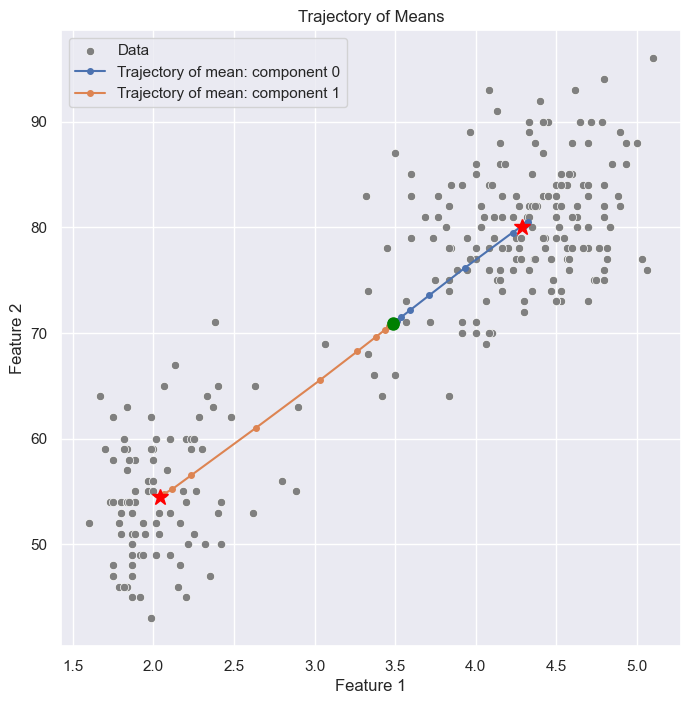

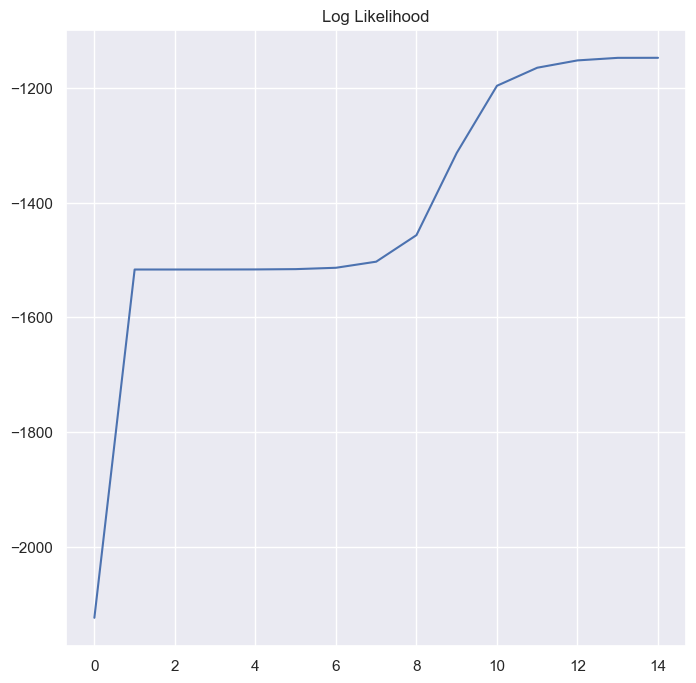

Training model with full covariance matrix


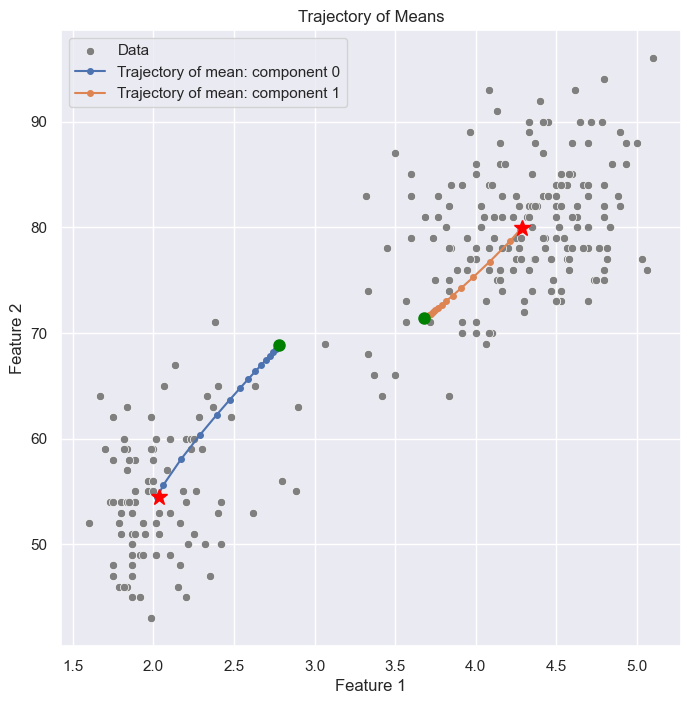

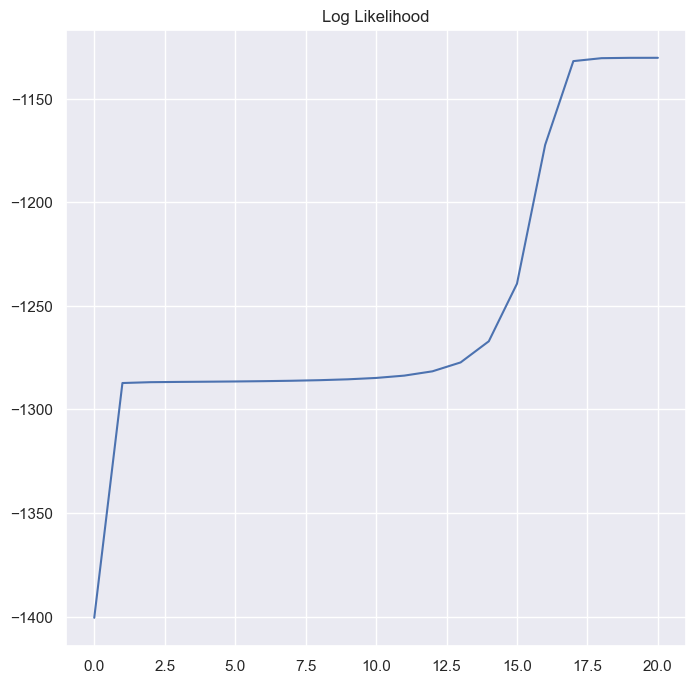

In [82]:
# Train model with spherical covariance matrix
print("Training model with spherical covariance matrix")
model = GaussianMixtureModel(
    n_components=2, max_iterations=1000, tolerance=1e-3, spherical_cov_mat=True
)
fit_log = model.fit(df.values)

# Plot trajectory
model.plot_mean_trajectory(
    fit_log, df.values, col_indices=[0, 1]
)
model.plot_log_likelihood(fit_log)

# Train model with full covariance matrix
print("Training model with full covariance matrix")
model = GaussianMixtureModel(
    n_components=2, max_iterations=1000, tolerance=1e-3, spherical_cov_mat=False
)
fit_log = model.fit(df.values)

# Plot trajectory
model.plot_mean_trajectory(
    fit_log, df.values, col_indices=[0, 1]
)
model.plot_log_likelihood(fit_log)

It is worth noting that the trajectory using spherical covariance matrix is qualitatively different from the trajectory using full covariance matrix. The trajectory using spherical covariance matrix is more linear, while the trajectory using full covariance matrix is more curved.

**Distribution of number of iterations for convergence** (using spherical covariance matrix):

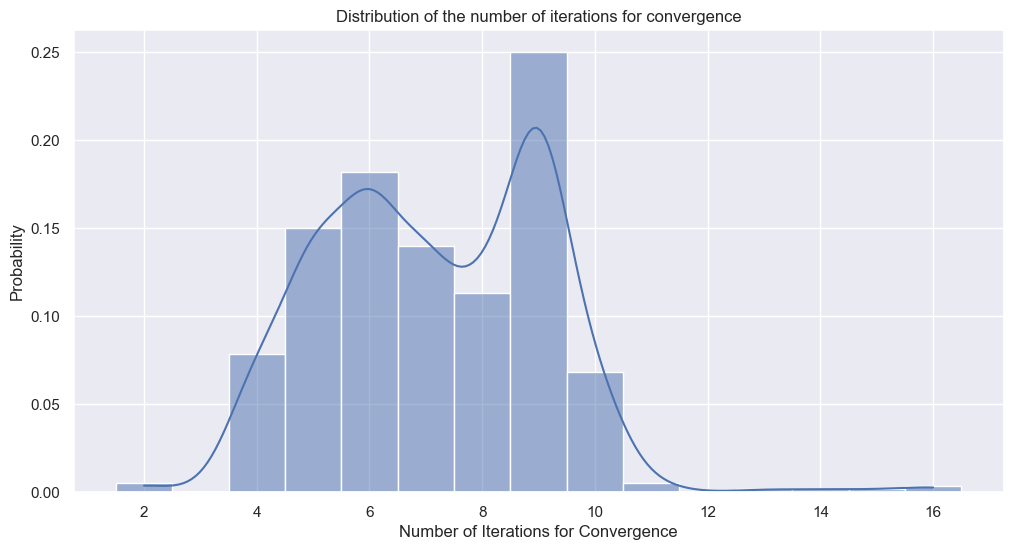

In [128]:
# Distribution of number of iterations for convergence
n_runs = 600
n_iter = []

for _ in range(n_runs):
    model = GaussianMixtureModel(
        n_components=2, max_iterations=100, tolerance=1e-3, spherical_cov_mat=True
    )
    run_log = model.fit(df.values)
    n_iter.append(run_log["converged"])

# Calculate mean and standard deviation for binning
mean_iter = np.mean(n_iter)
std_dev_iter = np.std(n_iter)

# Calculate bins based on mean and standard deviation
bins = np.arange(mean_iter - 3 * std_dev_iter, mean_iter + 3 * std_dev_iter + 1, 1)

# Plotting
plt.figure(figsize=(12, 6))
sns.set_theme(style="darkgrid")
histplot = sns.histplot(
    n_iter, bins=range(0, 20, 1), stat="probability", discrete=True, kde=True
)
plt.title("Distribution of the number of iterations for convergence")
plt.xlabel("Number of Iterations for Convergence")
plt.ylabel("Probability")
plt.show()

# **REFERENCES**

- [Gaussian Mixture Model](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model)

- [Gaussian Mixture Model - Expectation-Maximization Algorithm](https://brilliant.org/wiki/gaussian-mixture-model/)

- [GitHub - Ransaka](https://github.com/Ransaka/GMM-from-scratch)

- [Stopping Criteria for EM Algorithm](https://ieeexplore.ieee.org/document/4670413)